In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler

In [2]:
#!module load gcc/6.2.0
#!module load cuda/9.0

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0331 11:35:02.823071 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0331 11:35:02.825369 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0331 11:35:02.826927 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0331 11:35:04.040036 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The nam

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import tqdm
import glob
import joblib
import shutil
from glob import glob
from shutil import copyfile
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
#from mouse_rt_classifier.keras.util import DataGenAE
#from mouse_rt_classifier.io.util import jitter_frames
#from moseq2_pca.util import select_strel, clean_frames
from keras.utils import Sequence

from keras.layers import (Input, Dense, Conv2D, MaxPooling2D, 
                          UpSampling2D, Activation, BatchNormalization,
                          Flatten, Reshape, Lambda, Add, AveragePooling2D, LeakyReLU,
                          Concatenate)
from keras.initializers import Zeros
from keras.models import Model
# from keras.losses import mse
from keras import optimizers
from keras.objectives import mse
from keras import backend as K
from ruamel.yaml import YAML
import imageio
from pathlib import Path
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import keras
sns.set_style('whitegrid')

import os
abra=os.getcwd()

In [5]:
#the path of the autoencoder that was trained
autoencoder_pth = '/n/groups/datta/Dana/longtogeny39/longtogeny_model_training_set_1.h5'
#name the folder where the aggregated results will live
aggregated_results_folder='/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results'
aggregated_results_path=aggregated_results_folder+'/'
#name the folder where the reconstructed data will live
reconstructed_results_path='/n/groups/datta/Dana/longtogeny39/longtogeny39_reconstructed_results/'
#where is the data we want to reconstruct
data_path='/n/groups/datta/Dana/longtogeny39/*week*/session*/proc/*.h5'
yaml_path='/n/groups/datta/Dana/longtogeny39/*week*/session*/proc/*.yaml'
#what should we call the results video
video_name='/n/groups/datta/Dana/longtogeny39/longtogeny39_results_video'

video_length=500
example_number = 3

In [6]:
def h5_to_dict(h5file, path) -> dict:
    """
    Args:
        h5file (str or h5py.File): file path to the given h5 file or the h5 file handle
        path: path to the base dataset within the h5 file
    Returns:
        a dict with h5 file contents with the same path structure
    """
    if isinstance(h5file, str):
        with h5py.File(h5file, 'r') as f:
            out = _load_h5_to_dict(f, path)
    elif isinstance(h5file, h5py.File):
        out = _load_h5_to_dict(h5file, path)
    else:
        raise Exception('file input not understood - need h5 file path or file object')
    return out

In [7]:
def dict_to_h5(h5file, export_dict, path='/'):
    """
    ....
    """
    for key, item in export_dict.items():
        if isinstance(key, (tuple, int)):
            key = str(key)

        if isinstance(item, str):
            item = item.encode('utf8')

        if isinstance(item, np.ndarray) and item.dtype == np.object:
            item = _assert_object_array(item)
            # convert labels object to int16 and replace nans with -5
            if 'label' in key:
                item = replace_nan_labels(item)
            dt = h5py.special_dtype(vlen=item.flat[0].dtype)
            h5file.create_dataset(path+key, item.shape, dtype=dt, compression='gzip')
            for tup, idx in np.ndenumerate(item):
                if item[tup] is not None:
                    h5file[path+key][tup] = np.array(item[tup], dtype=dt).ravel()
        elif isinstance(item, (np.ndarray, list)):
            h5file.create_dataset(path+key, data=item, compression='gzip')
        elif isinstance(item, (np.int, np.float, str, bytes)):
            h5file.create_dataset(path+key, data=item)
        elif isinstance(item, dict):
            dict_to_h5(h5file, item, path + key + '/')
        else:
            raise ValueError('Cannot save {} type'.format(type(item)))

In [8]:
def read_yaml(yaml_file):
    with open(yaml_file, 'r') as f:
        dat = f.read()
        try:
            yaml = YAML(typ='safe')
            return_dict = yaml.load(dat)
        except AttributeError:
            yaml = YAML(typ='base')
            return_dict = yaml.load(dat)

    return return_dict

In [9]:
def get_pc_scores(frames, pc_components):
    return frames.reshape(len(frames), -1).dot(pc_components.T)

In [11]:
#Create a directory with aggregated results and yaml files
#the week name stuff is legacy code from working with mice of different ages (should still work)
os.mkdir(aggregated_results_folder)

for file in glob(data_path):
    i=file.find('session')
    w=file.find('weeks')-2
    session_name=file[i:i+22]
    week_name=file[w:w+10] +'_'
    if week_name[7:9] == '/s':
        week_name = week_name[0:7]+'_ch_'
    else:
        week_name = week_name[0:7]+'_lo_'
    shutil.copy(file, aggregated_results_path+week_name+session_name+'_results_00.h5')
    print(file)
    print(aggregated_results_path+week_name+session_name+'_results_00.h5')
for file in glob(yaml_path):
    i=file.find('session')
    w=file.find('weeks')-2
    session_name=file[i:i+22]
    week_name=file[w:w+10] +'_'
    if week_name[7:9] == '/s':
        week_name = week_name[0:7]+'_ch_'
    else:
        week_name = week_name[0:7]+'_lo_'
    shutil.copy(file, aggregated_results_path+week_name+session_name+'_results_00.yaml')

/n/groups/datta/Dana/longtogeny39/3_weeks/session_20190703171752/proc/results_00.h5
/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results/3_weeks_ch_session_20190703171752_results_00.h5
/n/groups/datta/Dana/longtogeny39/3_weeks/session_20190703171814/proc/results_00.h5
/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results/3_weeks_ch_session_20190703171814_results_00.h5
/n/groups/datta/Dana/longtogeny39/3_weeks/session_20190703144208/proc/results_00.h5
/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results/3_weeks_ch_session_20190703144208_results_00.h5
/n/groups/datta/Dana/longtogeny39/3_weeks/session_20190703171735/proc/results_00.h5
/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results/3_weeks_ch_session_20190703171735_results_00.h5
/n/groups/datta/Dana/longtogeny39/3_weeks/session_20190703144133/proc/results_00.h5
/n/groups/datta/Dana/longtogeny39/longtogeny39_aggregated_results/3_weeks_ch_session_20190703144133_results_00.h5
/n/groups/

In [12]:
cmap = plt.get_cmap('cubehelix', 256)
diff_cmap = plt.get_cmap('RdBu', 256)

In [13]:
autoencoder = keras.models.load_model(autoencoder_pth)

W0331 11:36:53.729631 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0331 11:36:53.772243 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0331 11:36:53.985168 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0331 11:36:54.608184 140662959601472 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_neare

In [14]:
f = Path(aggregated_results_folder)

for h5 in tqdm.tqdm_notebook(list(f.glob('*.h5'))):
    try:
        with h5py.File(h5, 'r') as f:
            use_frames = f['frames'][()]
        #reconstruction
        ae_frames = autoencoder.predict(use_frames[..., None], batch_size=512).squeeze()
        ae_frames[ae_frames > 120] = 0
        ae_frames[ae_frames < 5] = 0
        ae_frames = np.uint8(ae_frames)

        #copy and rename old h5 file to store reconstructed frames
        original_session_name=str(h5)[-36:-14] #THIS MAY NEED TO BE CHANGED FOR DIFFERENT EXPERIMENTS
        reconstructed_frames_path=(aggregated_results_path+'/'+original_session_name+'_reconstructed_results_00.h5')
        shutil.copy(str(h5),reconstructed_frames_path)
        print(original_session_name + ' reconstructed')

        #open reconstructed frame location, delete previous frames, and use ae frames as new frames
        new_data=h5py.File(reconstructed_frames_path,'r+')
        del new_data['frames']
        ae_frames=ae_frames*(100/np.max(ae_frames)) #rescale so data can be properly compressed
        ae_frames=ae_frames.astype(int)
        dset=new_data.create_dataset('frames',data=ae_frames,dtype='uint8')
    except:
        print(str(h5)[105:134]+' failed because you are a garbage researcher')

session_20191016152335 reconstructed
session_20190930170412 reconstructed
session_20190930161631 reconstructed
session_20190703144208 reconstructed
session_20190703115131 reconstructed
session_20190916154739 reconstructed
session_20190703151004 reconstructed
session_20191016140505 reconstructed
session_20191030185326 reconstructed
session_20191016143920 reconstructed
session_20191016140402 reconstructed
session_20190703171814 reconstructed
session_20190930180402 reconstructed
session_20191016140242 reconstructed
session_20190930180352 reconstructed
session_20191016143912 reconstructed
session_20191016143855 reconstructed
session_20190703194340 reconstructed
session_20190703171802 reconstructed
session_20191016152341 reconstructed
session_20190703194327 reconstructed
session_20190930180417 reconstructed
session_20190930173521 reconstructed
session_20190703163806 reconstructed
session_20191030173448 reconstructed
session_20190916151409 reconstructed
session_20190703102757 reconstructed
s

In [15]:
f = Path(aggregated_results_path)

for yaml in tqdm.tqdm_notebook(list(f.glob('*.yaml'))):
    
    #create new matching yaml files for reconstructed frames
    original_session_name=str(yaml)[-38:-16]
    reconstructed_frames_yaml_path=(aggregated_results_folder+'/'+original_session_name+'_reconstructed_results_00.yaml')
    shutil.copy(str(yaml),reconstructed_frames_yaml_path)
    print(original_session_name + ' reconstructed yaml file created')

session_20191030173506 reconstructed yaml file created
session_20190703115143 reconstructed yaml file created
session_20191016140402 reconstructed yaml file created
session_20190930180417 reconstructed yaml file created
session_20190930170353 reconstructed yaml file created
session_20191016160120 reconstructed yaml file created
session_20190703122850 reconstructed yaml file created
session_20190703160041 reconstructed yaml file created
session_20190930180352 reconstructed yaml file created
session_20190703175537 reconstructed yaml file created
session_20190930170404 reconstructed yaml file created
session_20190930180402 reconstructed yaml file created
session_20191030182405 reconstructed yaml file created
session_20190703144133 reconstructed yaml file created
session_20191030162747 reconstructed yaml file created
session_20190703102846 reconstructed yaml file created
session_20190703183252 reconstructed yaml file created
session_20190703160112 reconstructed yaml file created
session_20

In [16]:
os.mkdir(reconstructed_results_path)

In [17]:
os.chdir(aggregated_results_path)

In [18]:
!mv *reconstructed* ../*reconstructed*/

In [19]:
os.chdir(reconstructed_results_path)

In [20]:
import glob
result_h5=[] #create an empty matrix that will contain the addresses of the result files
result_yaml=[] #create an empty matrix that will contain the addresses of the result files
session_folders=[]
for file in glob.glob("*.h5"):
    result_h5.append(file)
    #make folders
    session_folder=file[0:22]
    print(session_folder)
    os.mkdir(session_folder)
    os.mkdir(session_folder+'/proc')
    session_folders.append(session_folder)
for file in glob.glob("*.yaml"):
    result_yaml.append(file)

session_20190930173505
session_20190703171814
session_20190703102709
session_20190703191253
session_20191030162424
session_20191016160130
session_20190703151004
session_20190703102757
session_20191030162723
session_20191030173506
session_20190703122921
session_20190703175607
session_20191030185326
session_20190916151423
session_20190703122912
session_20191016152318
session_20190703171752
session_20191016143920
session_20190703102807
session_20190703150943
session_20190703102846
session_20191030162747
session_20191030173448
session_20190703163820
session_20190703160041
session_20190930170412
session_20191030173456
session_20190703163806
session_20190930170353
session_20190703144133
session_20190930180409
session_20190930173457
session_20190916154739
session_20190703183252
session_20190703144115
session_20190930170404
session_20191016140540
session_20190703202215
session_20190916151409
session_20191016140505
session_20190703115153
session_20191016152326
session_20190703160053
session_201

In [21]:
# move the results .h5 and results . yaml files in to respective session/proc folders 
# here I am not actually moving I'm copying, it is a level of redundancy to make sure the files are good before deleting them
for n in result_h5:
    for i in range(len(session_folders)):
        if session_folders[i] in n:
            shutil.copy(n,session_folders[i]+'/proc')
for n in result_yaml:
    for i in range(len(session_folders)):
        if session_folders[i] in n:
            shutil.copy(n,session_folders[i]+'/proc')

#remove redundancy
#os.remove('*results*')

In [22]:
!ls

session_20190703102709
session_20190703102709_reconstructed_results_00.h5
session_20190703102709_reconstructed_results_00.yaml
session_20190703102757
session_20190703102757_reconstructed_results_00.h5
session_20190703102757_reconstructed_results_00.yaml
session_20190703102807
session_20190703102807_reconstructed_results_00.h5
session_20190703102807_reconstructed_results_00.yaml
session_20190703102846
session_20190703102846_reconstructed_results_00.h5
session_20190703102846_reconstructed_results_00.yaml
session_20190703110659
session_20190703110659_reconstructed_results_00.h5
session_20190703110659_reconstructed_results_00.yaml
session_20190703110739
session_20190703110739_reconstructed_results_00.h5
session_20190703110739_reconstructed_results_00.yaml
session_20190703110809
session_20190703110809_reconstructed_results_00.h5
session_20190703110809_reconstructed_results_00.yaml
session_20190703110841
session_20190703110841_reconstructed_results_00.h5
session_20190703110841_reconstructed_

In [23]:
!rm *results*

In [24]:
#make videos

os.mkdir(video_name)
os.chdir(video_name)


for e in range(example_number):
    os.mkdir('example_{}'.format(e))
    rand_frame=random.randint(0,5000)
    for i in range(video_length):
        plt.imsave("example_{}/{:04d}.png".format(e, i),  arr=np.hstack((use_frames[rand_frame+i,:,:],ae_frames[rand_frame+i,:,:])))
os.chdir(reconstructed_results_path)

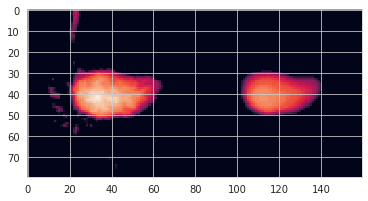

In [22]:
fig=plt.imshow(np.hstack((use_frames[rand_frame+i,:,:],ae_frames[rand_frame+i,:,:])))

In [25]:
os.chdir(video_name)

In [26]:
!ffmpeg -r 25 -i example_0/%04d.png -vb 20M example0.mp4

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.2.0 (crosstool-NG fa8859cb)
  configuration: --prefix=/home/ra206/miniconda3/envs/unetgpu --cc=/opt/conda/conda-bld/ffmpeg_1531088893642/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, image2, from 'example_0/%04d.png':
  Durati

In [27]:
os.chdir(abra)

In [28]:
!ls

3_weeks
3_weeks_lo
5_weeks
5_weeks_lo
7_weeks
7_weeks_lo
9_weeks
9_weeks_lo
longtogeny39_aggregated_results
longtogeny39_reconstructed_results
longtogeny39_results_video
longtogeny_model_training_set_1.h5
longtogeny_model_training_set_1_performance_on_session_20190916131152.pdf
PIP1_CREATE_UNET_TRAINING_DATASET_TEMPLATE_V1.ipynb
PIP2_UNET_TRAINING_TEMPLATE_V1.ipynb
PIP3_UNET_ENCODING_TEMPLATE_V1.ipynb
training_set_1
training_set_1.h5


In [29]:
!rm -r longtogeny39_aggregated_results